In [1]:
import os
import random

import albumentations
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio
import tensorflow as tf

from IPython.display import HTML, display
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.losses import binary_crossentropy
from pandas_path import path
from pathlib import Path
from skimage.morphology import label
from tensorflow.keras.optimizers import Adam

plt.style.use("ggplot")
%matplotlib inline

In [2]:
img_size = 512

In [4]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd() / "training_data"
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [6]:
#adding the path to the images and labels in the dataframe
train_metadata["feature_path"] = (str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path)

sources = ['change', 'extent', 'occurrence', 'recurrence', 'seasonality', 'transitions', 'nasadem']

for i in os.listdir('training_data/train_features'):
    for source in sources:
        if source in i:
            train_metadata[source] = DATA_PATH /'train_features' / i

train_metadata["label_path"] = (str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path)

In [7]:
train_metadata

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,change,transitions,recurrence,extent,seasonality,nasadem,occurrence,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,wvy29_vv,wvy29,wvy,vv,UK,2019-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
1080,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_labels...
1081,wvy30_vv,wvy30,wvy,vv,UK,2019-02-15,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featur...,/home/jovyan/thesis/training_data/train_featu

# Train Test Split

In [8]:
random.seed(123)
TRAIN_TEST_SPLIT = 3

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'hxu', 'tht']

In [9]:
test = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [10]:
def get_paths_by_chip(image_level_df):
    """
    Function that takes as input the meta_dataframe
    and return a dataframe with the chip id and both path for vv and vh.
    """
    
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        nasadem_path = group["nasadem"].values[0]
        change_path = group["change"].values[0]
        extent_path = group["extent"].values[0]
        occurrence_path = group["occurrence"].values[0]
        recurrence_path = group["recurrence"].values[0]
        seasonality_path = group["seasonality"].values[0]
        transitions_path = group["transitions"].values[0]
        paths.append([chip, vv_path, vh_path, nasadem_path, change_path, extent_path, occurrence_path, recurrence_path,
                      seasonality_path, transitions_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path", "nasadem", "change", "extent", "occurrence",
                                        "recurrence", "seasonality", "transitions"])

In [11]:
# Separate features from labels
test_meta_x = get_paths_by_chip(test)
test_meta_y = test[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_meta_x = get_paths_by_chip(train)
train_meta_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [12]:
train_meta_x.iloc[0][3]

PosixPath('/home/jovyan/thesis/training_data/train_features/wvy17_nasadem.tif')

# Get images

In [13]:
from IPython.display import HTML, display
def progress(value, max=100):
    return HTML("""
        <progress value='{value}', max='{max}', style='width: 100%'> {value} </progress>
    """.format(value=value, max=max))

In [16]:
def get_images(feature_path, label_path):
    features = []
    labels = []
    masks = []

    #progress bar
    out1 = display(progress(0, 100), display_id=True)
    out2 = display(progress(0, 100), display_id=True)

    paths = label_path['label_path'].to_list()
    nb_cols = len(paths)
    #load labels
    for i in range(nb_cols):
        with rasterio.open(paths[i]) as lp:
            img = lp.read(1)

        #create a list of mask for missing pixels
        mask = np.zeros(img.shape, dtype=np.uint8)
        mask[np.where(img == 255)] = 0

        labels.append(ma.array(img.astype('float32'), mask = mask))
        masks.append(mask)

        out1.update(progress((i/nb_cols)*100, 100))

    #load features
    cols = ["vv_path", "vh_path", "nasadem", "change", "extent", "seasonality", "occurrence", "recurrence", "transitions"]
    nb_cols = len(feature_path)
    for row in range(nb_cols) :
        images = []
        for col in cols:
            with rasterio.open(feature_path.loc[row, col]) as img:
          #load the tif file
                if(col in ["vv_path", "vh_path"]):
              #apply transformation: clip values out of -30;0 range and map them to 0; 255 range then convert to uint8
                    images.append(ma.array(np.uint8(np.clip(img.read(1), -30, 0)*(-8.4)), mask = masks[row]))
                elif col == "nasadem":
              #clip values > 255 and converto to uint8
                    images.append(ma.array(np.uint8(np.clip(img.read(1), 0, 255)), mask = masks[row]))
                else:
              #no transformation, values are already between 0 and 255 and in uint8 format
                  images.append(ma.array(img.read(1), mask = masks[row]))

        features.append(np.stack(images, axis=-1))
        out2.update(progress((row/nb_cols)*100, 100))       

    return np.array(features), np.array(labels)

In [17]:
train_x, train_y = get_images(train_meta_x, train_meta_y)
test_x, test_y = get_images(test_meta_x, test_meta_y)

In [18]:
#change shape from (512,512, 3) to (..,.., 9) in CustomDataGen
train_x[0].shape

(512, 512, 9)

# Image augmentations

In [19]:
random.seed(123)

transform = albumentations.Compose(
    [
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.OneOf([
            albumentations.MotionBlur(p=0.2),
            albumentations.MedianBlur(blur_limit=3, p=0.1),
            albumentations.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
    ]
)

In [20]:
train_x_aug = []
train_y_aug = []
for i in range(len(train_x)):
    t = transform(image=train_x[i], mask=train_y[i])
    train_x_aug.append(t['image'])
    train_y_aug.append(t['mask'])

train_x_aug = np.array(train_x_aug)
train_y_aug = np.array(train_y_aug)

In [21]:
train_x_final = np.concatenate((train_x, train_x_aug))
train_y_final = np.concatenate((train_y, train_y_aug))

# Loss function

In [22]:
# https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
def DiceLoss_square(y_true, y_pred, smooth=1):
  #create the missing data mask
    mask = tf.math.not_equal(y_true, 255)
  #apply the mask
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    return 1-((2. * intersection + smooth) / (K.sum(K.square(y_true_f),-1) + K.sum(K.square(y_pred_f),-1) + smooth))

def DiceLoss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1-((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [23]:
#tversky 
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred, alpha=0.75):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [24]:
def IOU_coef(y_true, y_pred):
  #create the missing data mask
    mask = tf.math.not_equal(y_true, 255)
    #apply the mask
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    #make all values > 0.5 a 1 and all others a 0
    y_pred = tf.cast((y_pred > 0.5), dtype=tf.float32)
    #y_pred = tf.math.multiply(tf.math.greater(y_pred, 0.5),1.0)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# https://www.youtube.com/watch?v=BNPW1mYbgS4
def IOULoss(y_true, y_pred):
    return -IOU_coef(y_true, y_pred)

In [25]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters,
               kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [26]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [27]:
input_img = Input((img_size, img_size, 9), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=DiceLoss_square, metrics=[IOU_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 512, 512, 9  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  1312        ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [42]:
MODEL_NAME = "tversky_tensorflow2.h5"    #here you can choose the name of the h5 file where the model fill be saved

In [28]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    # ModelCheckpoint('/models/' + MODEL_NAME, verbose=1, save_best_only=True, save_weights_only=False)
]

In [30]:
print(type(train_x_final[0,0,0,8]), type(train_y[0,0,0]))
print(type(test_x[0,0,0,0]), type(test_y[0,0,0]))

<class 'numpy.uint8'> <class 'numpy.float32'>
<class 'numpy.uint8'> <class 'numpy.float32'>


In [31]:
print("max train_x:", np.amax(train_x), "min train_x:", np.amin(train_x))
print("max train_x_aug:", np.amax(train_x_aug), "min train_x_aug:", np.amin(train_x_aug))
print("max test_x:", np.amax(test_x), "min test_x:", np.amin(test_x))
print("max train_y:", np.amax(train_y), "min train_y:", np.amin(train_y))
print("max test_y:", np.amax(test_y), "min test_y:", np.amin(test_y))

max train_x: 254 min train_x: 0
max train_x_aug: 254 min train_x_aug: 0
max test_x: 254 min test_x: 0
max train_y: 255.0 min train_y: 0.0
max test_y: 255.0 min test_y: 0.0


In [29]:
results = model.fit(train_x_final, train_y_final, batch_size=8, epochs=100, callbacks=callbacks,
                    validation_data=(test_x, test_y))

2022-11-02 21:51:00.255646: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1972371456 exceeds 10% of free system memory.
2022-11-02 21:51:00.886762: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1972371456 exceeds 10% of free system memory.


Epoch 1/100


2022-11-02 21:51:04.279973: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-02 21:51:04.280454: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


105/105 [==============================] - 55s 392ms/step - loss: 0.3326 - IOU_coef: 0.5480 - val_loss: 0.7845 - val_IOU_coef: 0.1242 - lr: 0.0010
Epoch 2/100
105/105 [==============================] - 35s 334ms/step - loss: 0.2534 - IOU_coef: 0.5899 - val_loss: 0.5523 - val_IOU_coef: 0.2507 - lr: 0.0010
Epoch 3/100
105/105 [==============================] - 35s 337ms/step - loss: 0.2267 - IOU_coef: 0.6164 - val_loss: 0.5163 - val_IOU_coef: 0.2764 - lr: 0.0010
Epoch 4/100
105/105 [==============================] - 36s 339ms/step - loss: 0.2190 - IOU_coef: 0.6188 - val_loss: 0.3234 - val_IOU_coef: 0.4845 - lr: 0.0010
Epoch 5/100
105/105 [==============================] - 36s 341ms/step - loss: 0.2231 - IOU_coef: 0.6126 - val_loss: 0.3298 - val_IOU_coef: 0.4832 - lr: 0.0010
Epoch 6/100
105/105 [==============================] - 36s 343ms/step - loss: 0.2061 - IOU_coef: 0.6440 - val_loss: 0.3339 - val_IOU_coef: 0.4643 - lr: 0.0010
Epoch 7/100
105/105 [==============================] - ETA

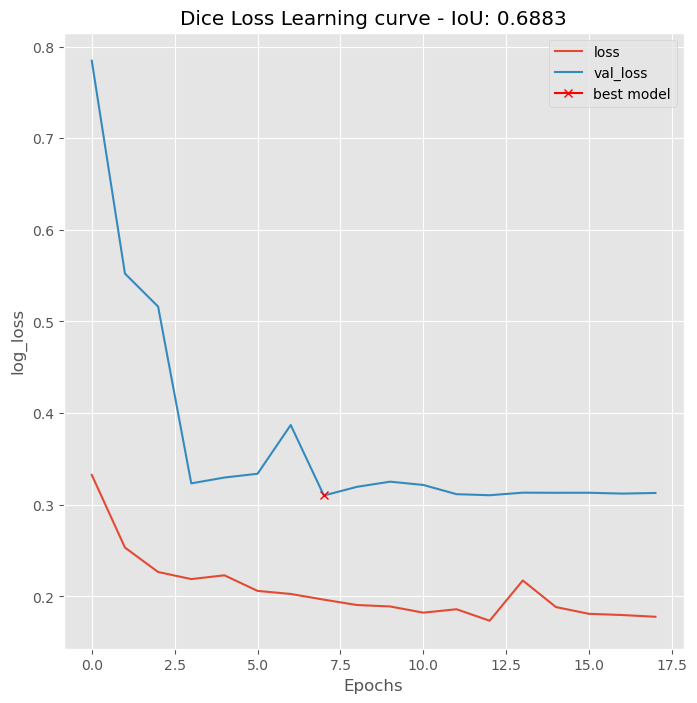

In [30]:
plt.figure(figsize=(8, 8))
plt.title(f"Dice Loss Learning curve - IoU: {round(max(results.history['IOU_coef']), 4)}")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

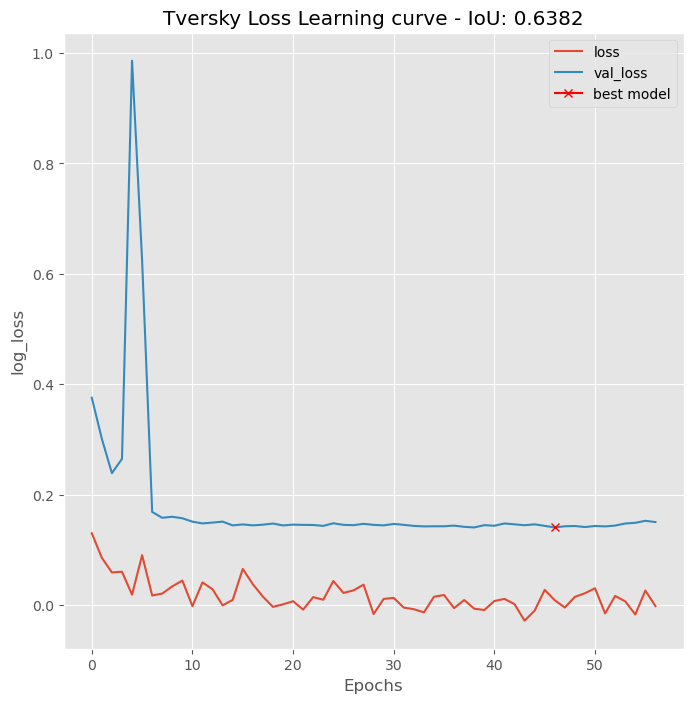

In [42]:
plt.figure(figsize=(8, 8))
plt.title(f"Tversky Loss Learning curve - IoU: {round(max(results.history['IOU_coef']), 4)}")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

DiceLoss with difficult chips in training set: 0.6189

DiceLoss_square with difficult chips in training set: 0.6883

Tversky with difficult chips in training set: 0.6382